# Comparative Performance Analysis of Sorting Algorithms Using Simulation in Python

**Authors:**

| Name | ID |
| --- | --- |
| Heyeman Abdisa | ETS0632/13 |
| Hikma Anwar | ETS0633/13 |
| Hunde Desalegn | ETS0643/13 |
| Ifa Tolla | ETS0647/13 |
| Iman Ahmed | ETS0648/13 |
| Senait Mengesha | ETS1602/13 |

**Submission Date:** January 23, 2025

This notebook conducts a comprehensive performance analysis of various sorting algorithms, including both comparison-based (Bubble Sort, Insertion Sort, Merge Sort, QuickSort) and non-comparison-based (Counting Sort) methods. The analysis evaluates runtime and memory usage across different input sizes and data distributions using Python simulations.

## Prerequisites
- Python 3.6 or higher
- Jupyter Notebook
- Install the required libraries using the following command:
```bash
pip install numpy pandas matplotlib seaborn
```



## **Table of Contents**
1. [Import Necessary Libraries](#Import-Libraries)
2. [Data Generation Module](#Data-Generation)
3. [Sorting Algorithms Module](#Sorting-Algorithms)
4. [Performance Tracking Module](#Performance-Tracking)
5. [Simulation Controller Module](#Simulation-Controller)
6. [Helper Functions](#Helper-Functions)
7. [Visualization Module](#Visualization)
8. [Main Execution Script](#Main-Execution)
9. [Running the Simulation and Generating Visualizations](#Running-Simulation)


In [30]:
import random
import time
import tracemalloc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Configure seaborn aesthetics
sns.set_theme(style="whitegrid")

# Set the random seed
random.seed(42)
np.random.seed(42)

## **Data Generation Module**

This module is responsible for generating synthetic datasets based on specified input sizes and distributions. It supports three types of data distributions:
- **Random:** Completely unsorted data.
- **Nearly Sorted:** Data mostly sorted with a small percentage of elements shuffled.
- **Reverse Sorted:** Data sorted in descending order.

In [31]:
class DataGenerator:
    def __init__(self, size, distribution, max_value=None):
        """
        Initializes the DataGenerator with the specified parameters.

        :param size: Number of elements in the dataset.
        :param distribution: Type of data distribution ('random', 'nearly_sorted', 'reverse_sorted').
        :param max_value: Maximum integer value in the dataset (relevant for Counting Sort).
        """
        self.size = size
        self.distribution = distribution
        self.max_value = max_value  # Relevant for Counting Sort

    def generate(self):
        """
        Generates a dataset based on the specified size and distribution.

        :return: List of integers representing the dataset.
        """
        if self.distribution == 'random':
            return self.generate_random_data()
        elif self.distribution == 'nearly_sorted':
            return self.generate_nearly_sorted_data()
        elif self.distribution == 'reverse_sorted':
            return self.generate_reverse_sorted_data()
        else:
            raise ValueError("Unknown distribution type")

    def generate_random_data(self):
        """
        Generates a randomly ordered dataset.

        :return: List of integers.
        """
        # To ensure unique elements, use sample. If duplicates are allowed, use randint
        return random.sample(range(0, self.size * 10), self.size)

    def generate_nearly_sorted_data(self):
        """
        Generates a nearly sorted dataset with a small fraction of elements shuffled.

        :return: List of integers.
        """
        data = list(range(self.size))
        shuffle_fraction = 0.05  # 5% of elements are shuffled
        num_swaps = int(shuffle_fraction * self.size)
        for _ in range(num_swaps):
            idx1, idx2 = random.sample(range(self.size), 2)
            data[idx1], data[idx2] = data[idx2], data[idx1]
        return data

    def generate_reverse_sorted_data(self):
        """
        Generates a reverse sorted dataset.

        :return: List of integers.
        """
        return list(range(self.size, 0, -1))

## **Sorting Algorithms Module**

This module defines the base class for sorting algorithms and their specific implementations. Each sorting algorithm inherits from the `SortingAlgorithm` base class and implements the `sort` method.

In [32]:
class SortingAlgorithm:
    def sort(self, data):
        """
        Sorts the provided data.

        :param data: List of integers to sort.
        :return: Sorted list of integers.
        """
        raise NotImplementedError("Must implement sort method")

class BubbleSort(SortingAlgorithm):
    def sort(self, data):
        arr = data.copy()
        n = len(arr)
        for i in range(n):
            for j in range(0, n - i - 1):
                if arr[j] > arr[j + 1]:
                    arr[j], arr[j + 1] = arr[j + 1], arr[j]
        return arr

class InsertionSort(SortingAlgorithm):
    def sort(self, data):
        arr = data.copy()
        for i in range(1, len(arr)):
            key = arr[i]
            j = i - 1
            while j >=0 and key < arr[j]:
                arr[j + 1] = arr[j]
                j -= 1
            arr[j + 1] = key
        return arr

class MergeSort(SortingAlgorithm):
    def sort(self, data):
        arr = data.copy()
        self.merge_sort(arr)
        return arr

    def merge_sort(self, arr):
        if len(arr) > 1:
            mid = len(arr) // 2
            L = arr[:mid]
            R = arr[mid:]

            self.merge_sort(L)
            self.merge_sort(R)

            i = j = k = 0

            while i < len(L) and j < len(R):
                if L[i] < R[j]:
                    arr[k] = L[i]
                    i += 1
                else:
                    arr[k] = R[j]
                    j += 1
                k += 1

            while i < len(L):
                arr[k] = L[i]
                i += 1
                k += 1

            while j < len(R):
                arr[k] = R[j]
                j += 1
                k += 1

class QuickSort(SortingAlgorithm):
    def sort(self, data):
        arr = data.copy()
        self.quick_sort(arr, 0, len(arr) - 1)
        return arr

    def quick_sort(self, arr, low, high):
        if low < high:
            pi = self.partition(arr, low, high)
            self.quick_sort(arr, low, pi - 1)
            self.quick_sort(arr, pi + 1, high)

    def partition(self, arr, low, high):
        pivot_index = random.randint(low, high)
        arr[pivot_index], arr[high] = arr[high], arr[pivot_index]
        pivot = arr[high]
        i = low - 1
        for j in range(low, high):
            if arr[j] < pivot:
                i +=1
                arr[i], arr[j] = arr[j], arr[i]
        arr[i+1], arr[high] = arr[high], arr[i+1]
        return i +1

class CountingSort(SortingAlgorithm):
    def sort(self, data):
        if not data:
            return []
        max_val = max(data)
        count = [0] * (max_val + 1)
        for num in data:
            count[num] += 1
        sorted_arr = []
        for num, freq in enumerate(count):
            sorted_arr.extend([num] * freq)
        return sorted_arr

## **Performance Tracking Module**

This module measures and records the runtime and memory usage of sorting algorithms during execution. It uses Python's `time` and `tracemalloc` libraries for accurate tracking.

In [33]:
class PerformanceTracker:
    def __init__(self):
        """
        Initializes the PerformanceTracker to measure runtime and memory usage.
        """
        self.runtime = 0
        self.memory = 0

    def track(self, sort_function, data):
        """
        Executes the sorting function and tracks runtime and memory usage.

        :param sort_function: The sorting function to execute.
        :param data: The dataset to sort.
        :return: Tuple containing runtime (seconds) and memory usage (MB).
        """
        tracemalloc.start()
        start_time = time.perf_counter()
        sorted_data = sort_function(data)
        end_time = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.runtime = end_time - start_time
        self.memory = peak / 10**6  # Convert to MB

        # Optional: Verify correctness
        # sorted_reference = sorted(data)
        # assert sorted_data == sorted_reference, "Sorting algorithm failed!"

        return self.runtime, self.memory

## **Simulation Controller Module**

This module orchestrates the simulation runs, managing data generation, algorithm execution, and performance tracking across all configurations.

In [34]:
class SimulationController:
    def __init__(self, algorithms, input_sizes, distributions, trials, counting_sort_k=None):
        """
        Initializes the SimulationController with the specified parameters.

        :param algorithms: List of sorting algorithm instances to evaluate.
        :param input_sizes: List of input sizes (number of elements) to test.
        :param distributions: List of data distributions ('random', 'nearly_sorted', 'reverse_sorted').
        :param trials: Number of trials to conduct for each configuration.
        :param counting_sort_k: Function to determine the max value (k) for Counting Sort.
        """
        self.algorithms = algorithms
        self.input_sizes = input_sizes
        self.distributions = distributions
        self.trials = trials
        self.counting_sort_k = counting_sort_k  # Function to determine k
        self.results = []

    def run(self):
        """
        Executes the simulation across all configurations and records performance metrics.
        """
        total_runs = len(self.input_sizes) * len(self.distributions) * self.trials * len(self.algorithms)
        current_run = 0

        for size in self.input_sizes:
            for distribution in self.distributions:
                for trial in range(self.trials):
                    # Generate data
                    data_gen = DataGenerator(size, distribution)
                    data = data_gen.generate()

                    # Determine max value for Counting Sort
                    if self.counting_sort_k:
                        max_val = self.counting_sort_k(size, distribution)
                        # Adjust data to fit Counting Sort constraints
                        data = [min(num, max_val) for num in data]

                    for algo in self.algorithms:
                        current_run += 1
                        print(f"Running {algo.__class__.__name__} | Size: {size} | Distribution: {distribution} | Trial: {trial + 1} ({current_run}/{total_runs})")

                        tracker = PerformanceTracker()
                        runtime, memory = tracker.track(algo.sort, data)
                        self.results.append({
                            'Algorithm': algo.__class__.__name__,
                            'Input Size': size,
                            'Distribution': distribution,
                            'Trial': trial + 1,
                            'Runtime (s)': runtime,
                            'Memory (MB)': memory
                        })

    def get_results(self):
        """
        Retrieves the recorded performance metrics as a pandas DataFrame.

        :return: pandas DataFrame containing performance metrics.
        """
        return pd.DataFrame(self.results)

## **Helper Functions**

These functions assist in determining the value range (`k`) for Counting Sort and validating the integrity of generated data.

In [35]:
def determine_max_value(size, distribution):
    """
    Determines the maximum value (k) for Counting Sort based on input size and distribution.

    :param size: Number of elements in the dataset.
    :param distribution: Type of data distribution.
    :return: Integer representing the maximum value.
    """
    return size * 10  # Example strategy: k = 10n

def validate_data(data, distribution):
    """
    Validates the generated data based on the distribution type.

    :param data: List of integers representing the dataset.
    :param distribution: Type of data distribution.
    :return: Boolean indicating whether the data is valid.
    """
    if distribution == 'random':
        return True  # No specific pattern expected
    elif distribution == 'nearly_sorted':
        # Check if the number of inversions is within expected range
        inversions = count_inversions(data)
        expected_inversions = int(0.05 * len(data))
        return inversions <= expected_inversions
    elif distribution == 'reverse_sorted':
        return data == sorted(data, reverse=True)
    else:
        return False

def count_inversions(arr):
    """
    Counts the number of inversions in the array.

    :param arr: List of integers.
    :return: Integer count of inversions.
    """
    inv_count = 0
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            if arr[i] > arr[j]:
                inv_count += 1
    return inv_count

## **Visualization Module**

This module generates visual representations of the collected performance metrics, including runtime and memory usage across different algorithms, input sizes, and data distributions.

In [36]:
def plot_runtime_vs_input_size(results_df):
    """
    Plots Runtime vs. Input Size for different sorting algorithms and data distributions.

    :param results_df: pandas DataFrame containing performance metrics.
    """
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=results_df, x='Input Size', y='Runtime (s)', hue='Algorithm', style='Distribution', markers=True, dashes=False)
    plt.title('Runtime vs. Input Size for Different Sorting Algorithms')
    plt.xlabel('Input Size')
    plt.ylabel('Runtime (seconds)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(title='Algorithm & Distribution', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('runtime_vs_input_size.png')
    plt.show()

def plot_memory_usage_vs_input_size(results_df):
    """
    Plots Memory Usage vs. Input Size for different sorting algorithms and data distributions.

    :param results_df: pandas DataFrame containing performance metrics.
    """
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=results_df, x='Input Size', y='Memory (MB)', hue='Algorithm', style='Distribution', markers=True, dashes=False)
    plt.title('Memory Usage vs. Input Size for Different Sorting Algorithms')
    plt.xlabel('Input Size')
    plt.ylabel('Memory Usage (MB)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(title='Algorithm & Distribution', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('memory_usage_vs_input_size.png')
    plt.show()

def plot_distribution_impact(results_df):
    """
    Plots the impact of data distribution on algorithm runtime.

    :param results_df: pandas DataFrame containing performance metrics.
    """
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=results_df, x='Input Size', y='Runtime (s)', hue='Algorithm', style='Distribution', markers=True, dashes=False)
    plt.title('Runtime vs. Input Size by Data Distribution')
    plt.xlabel('Input Size')
    plt.ylabel('Runtime (seconds)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(title='Algorithm & Distribution', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('distribution_impact_runtime.png')
    plt.show()


## **Main Execution Script**

This section sets up the simulation parameters, initializes the simulation controller, runs the simulations, and saves the results.

In [37]:
def main():
    # Define sorting algorithms to evaluate
    algorithms = [
        BubbleSort(),
        InsertionSort(),
        MergeSort(),
        QuickSort(),
        CountingSort()
    ]

    # Define input sizes
    input_sizes = [100, 250, 500, 1000, 5000, 10000, 20000]

    # Define data distributions
    distributions = ['random', 'nearly_sorted', 'reverse_sorted']

    # Define number of trials per configuration
    trials = 5

    # Initialize SimulationController
    simulation = SimulationController(
        algorithms=algorithms,
        input_sizes=input_sizes,
        distributions=distributions,
        trials=trials,
        counting_sort_k=determine_max_value
    )

    # Run simulations
    simulation.run()

    # Retrieve results
    results_df = simulation.get_results()

    # Save results to CSV
    results_df.to_csv('sorting_algorithm_performance.csv', index=False)
    print("\nSimulation complete. Results saved to 'sorting_algorithm_performance.csv'.")

    # Optional: Display summary statistics
    print("\nSummary Statistics:")
    summary = results_df.groupby(['Algorithm', 'Input Size', 'Distribution']).agg({
        'Runtime (s)': ['mean', 'std'],
        'Memory (MB)': ['mean', 'std']
    }).reset_index()
    summary.columns = ['Algorithm', 'Input Size', 'Distribution', 'Runtime Mean (s)', 'Runtime Std (s)', 'Memory Mean (MB)', 'Memory Std (MB)']
    print(summary)

    # Optional: Save summary to CSV
    summary.to_csv('average_sorting_performance.csv', index=False)
    print("\nSummary statistics saved to 'average_sorting_performance.csv'.")

def generate_visualizations():
    # Load results
    results_df = pd.read_csv('sorting_algorithm_performance.csv')

    # Plot Runtime vs. Input Size
    plot_runtime_vs_input_size(results_df)

    # Plot Memory Usage vs. Input Size
    plot_memory_usage_vs_input_size(results_df)

    # Plot Distribution Impact on Runtime
    plot_distribution_impact(results_df)
    
def run_simulation():
    # Increase the recursion limit
    sys.setrecursionlimit(1 << 25)
    main()


## **Running the Simulation and Generating Visualizations**

Execute the main simulation and generate the corresponding visualizations. This will perform the simulations across all defined configurations and create plots to visualize the performance metrics.

Running BubbleSort | Size: 100 | Distribution: random | Trial: 1 (1/525)
Running InsertionSort | Size: 100 | Distribution: random | Trial: 1 (2/525)
Running MergeSort | Size: 100 | Distribution: random | Trial: 1 (3/525)
Running QuickSort | Size: 100 | Distribution: random | Trial: 1 (4/525)
Running CountingSort | Size: 100 | Distribution: random | Trial: 1 (5/525)
Running BubbleSort | Size: 100 | Distribution: random | Trial: 2 (6/525)
Running InsertionSort | Size: 100 | Distribution: random | Trial: 2 (7/525)
Running MergeSort | Size: 100 | Distribution: random | Trial: 2 (8/525)
Running QuickSort | Size: 100 | Distribution: random | Trial: 2 (9/525)
Running CountingSort | Size: 100 | Distribution: random | Trial: 2 (10/525)
Running BubbleSort | Size: 100 | Distribution: random | Trial: 3 (11/525)
Running InsertionSort | Size: 100 | Distribution: random | Trial: 3 (12/525)
Running MergeSort | Size: 100 | Distribution: random | Trial: 3 (13/525)
Running QuickSort | Size: 100 | Distrib

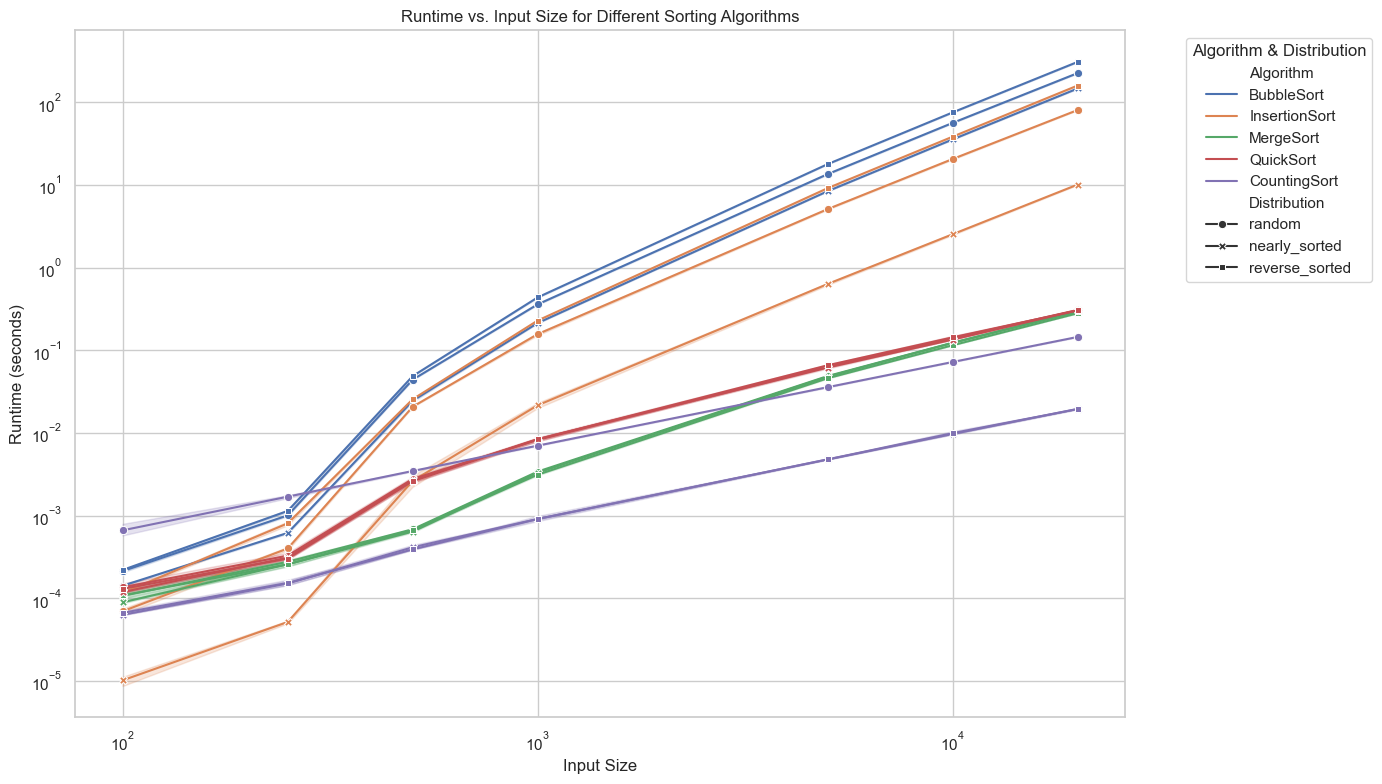

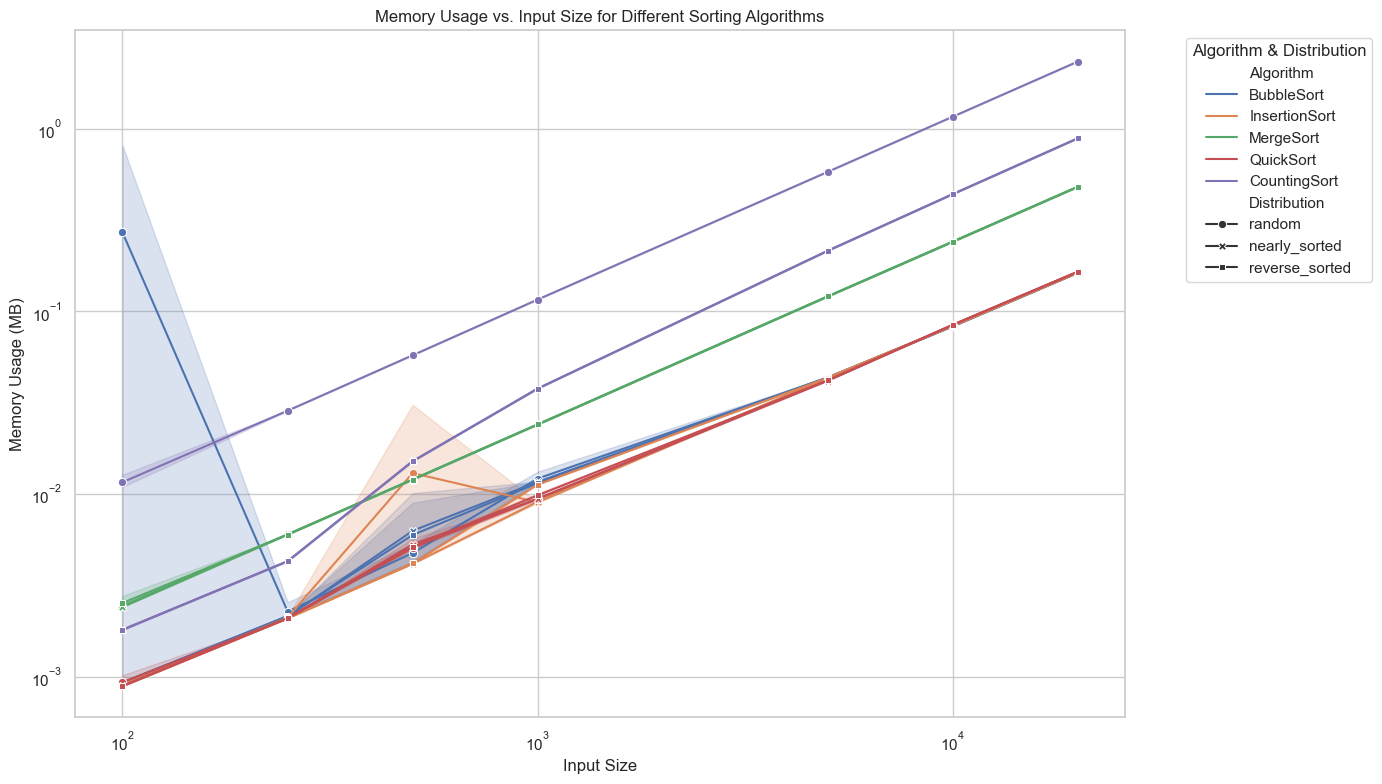

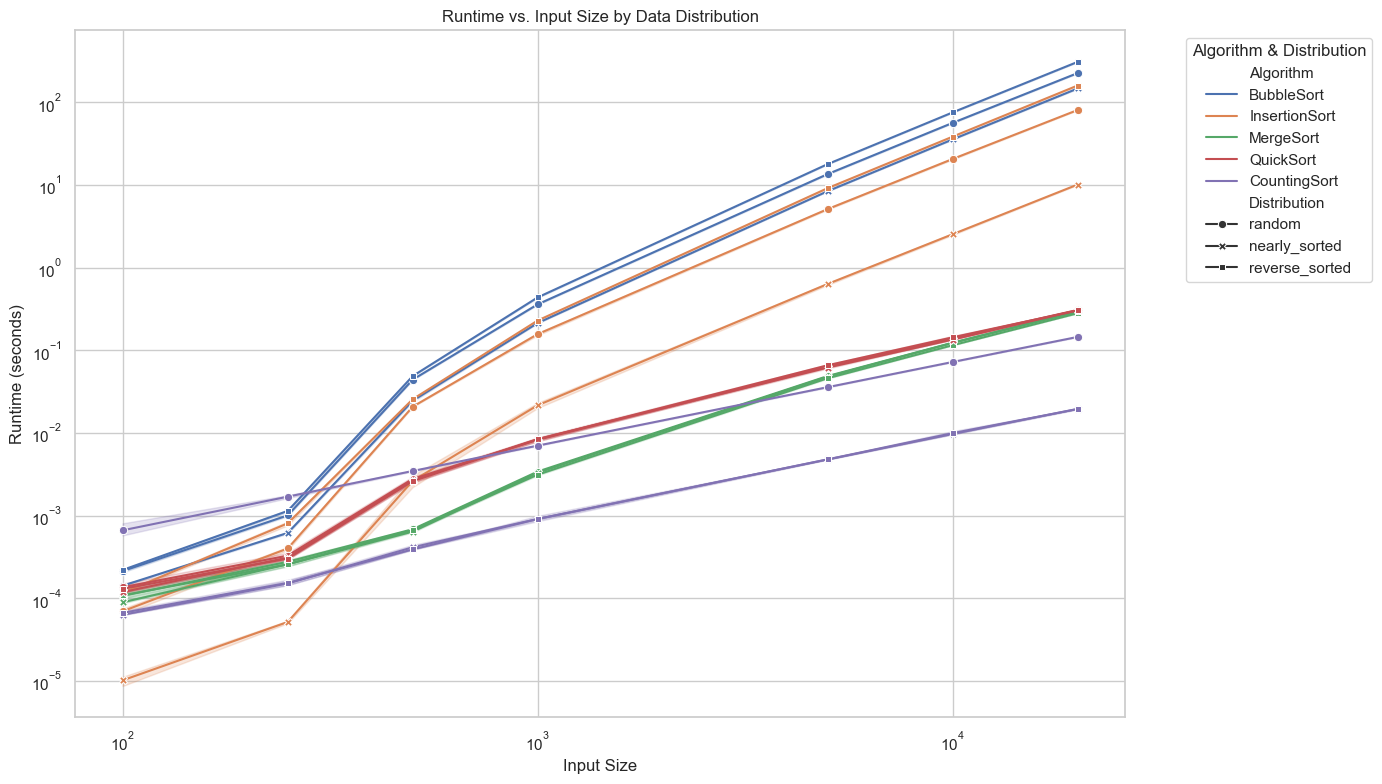

In [29]:
run_simulation()
generate_visualizations()